In [1]:
%matplotlib inline
from lynxes.model import DeployedModel
from lynxes.model import InMemoryModel
from lynxes.core.explanations import Interpretation
import pandas as pd
import numpy as np
import json
import requests
np.random.seed(1)
from __future__ import print_function

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def input_formatter(data):
    # Convert a data frame of the format 
    #     Status.of.existing.checking.account  Duration.in.month Credit.history Savings.account.bonds 
    # 0                                 A11                  6            A34            A65
    # 1                                 A12                 48            A32            A61 
    # to the following format:
    # {"input":[{"Status.of.existing.checking.account": "A11", "Duration.in.month": 24, "Credit.history": "A32", 
    # "Savings.account.bonds": "A63"}, {"Status.of.existing.checking.account": "A12", "Duration.in.month": 23, 
    # "Credit.history": "A31", "Savings.account.bonds": "A65"}, {"Status.of.existing.checking.account": "A12", 
    # "Duration.in.month": 23, "Credit.history": "A31", "Savings.account.bonds": "A65"}]}
    #if not isinstance(data, pd.DataFrame):
    #        raise TypeError("must be a dataframe")
    return {"input": pd.DataFrame(data).to_json(orient='records')}
    
def output_formatter(response, key='probability'):
    return np.array(response.json()['probability'])

In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
feature_name = ['Status of existing checking account', 'Duration in month', 'Credit history'
, 'Purpose', 'Credit amount', 'Savings account.bonds', 'Employment years'
, 'Installment rate in percentage of disposable income'
, 'Personal status and sex', 'Other debtors.guarantors', 'Present residence since'
, 'Property', 'Age in years', 'Other installment plans', 'Housing', 'Number of existing credits at this bank'
, 'Job', 'Number of people being liable to provide maintenance for', 'Telephone', 'Foreign worker', 'Status']

f_n = [f.replace(' ', '.') for f in feature_name]
input_data = pd.read_csv(url, sep=' ', names=f_n)
pd.DataFrame(input_data).head(1)

,Status.of.existing.checking.account,Duration.in.month,Credit.history,Purpose,Credit.amount,Savings.account.bonds,Employment.years,Installment.rate.in.percentage.of.disposable.income,Personal.status.and.sex,Other.debtors.guarantors,...,Property,Age.in.years,Other.installment.plans,Housing,Number.of.existing.credits.at.this.bank,Job,Number.of.people.being.liable.to.provide.maintenance.for,Telephone,Foreign.worker,Status
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1


In [4]:
deployed_model_uri = "http://datsci.dev:8000/predict"

In [5]:
# Filter on the features as needed by the model
selected_input_data = input_data[['Status.of.existing.checking.account', 'Duration.in.month', 'Credit.history', 
                                  'Savings.account.bonds']]
#print(type(selected_input_data.values))
print(selected_input_data.head(2))
#input_formatter(selected_input_data.values)
print(type(selected_input_data))

  Status.of.existing.checking.account  Duration.in.month Credit.history  \
0                                 A11                  6            A34   
1                                 A12                 48            A32   

  Savings.account.bonds  
0                   A65  
1                   A61  
<class 'pandas.core.frame.DataFrame'>


In [6]:
# Convert the dataframe to the following the required format:
input_data = input_formatter(selected_input_data.head(5))
print(input_data['input'])

[{"Status.of.existing.checking.account":"A11","Duration.in.month":6,"Credit.history":"A34","Savings.account.bonds":"A65"},{"Status.of.existing.checking.account":"A12","Duration.in.month":48,"Credit.history":"A32","Savings.account.bonds":"A61"},{"Status.of.existing.checking.account":"A14","Duration.in.month":12,"Credit.history":"A34","Savings.account.bonds":"A61"},{"Status.of.existing.checking.account":"A11","Duration.in.month":42,"Credit.history":"A32","Savings.account.bonds":"A61"},{"Status.of.existing.checking.account":"A11","Duration.in.month":24,"Credit.history":"A33","Savings.account.bonds":"A61"}]


In [7]:
# Just testing post request independent of deploy
r = requests.post(deployed_model_uri, json=input_data)

In [8]:
dep_model = DeployedModel(deployed_model_uri,
                         input_formatter,
                         output_formatter,
                         examples=selected_input_data.head(5))

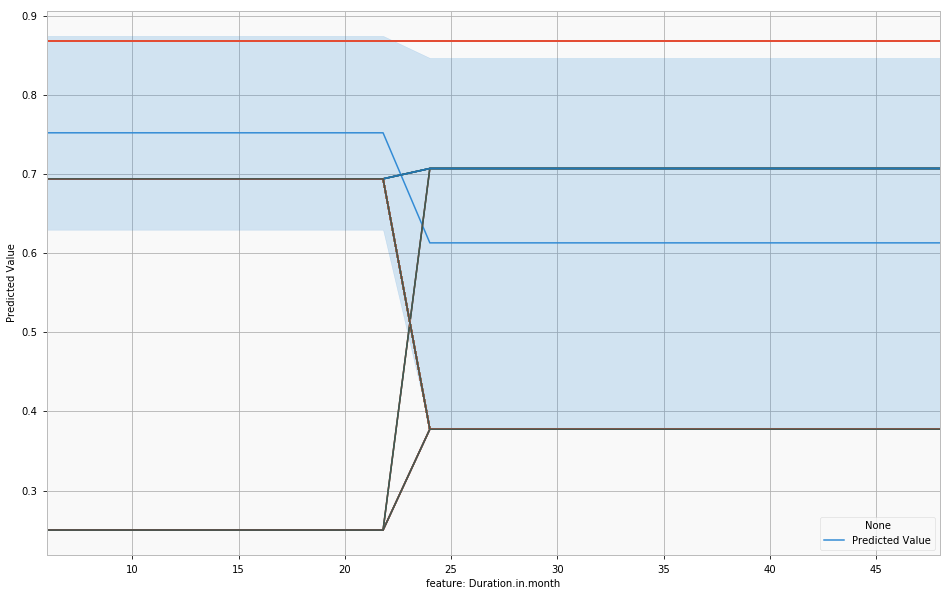

In [47]:
feature_names = np.array(selected_input_data.columns)
interpreter = Interpretation(log_level=30)
interpreter.load_data(selected_input_data.head(100), feature_names=feature_names)

plots = interpreter.partial_dependence.plot_partial_dependence(['Duration.in.month'],
                                                         dep_model,
                                                         with_variance=True, 
                                                         sampling_strategy='random-choice',
                                                         n_jobs=4, grid_resolution=10, n_samples = 500, sample=True)
ax = plots[0][1]
ice_.plot(ax=ax,legend=False)


In [34]:
ice = interpreter.ice.partial_dependence(['Duration.in.month'],
                                        dep_model,
                                        sampling_strategy='random-choice',
                                        n_jobs=1, grid_resolution=10, n_samples = 500, sample=True)

In [35]:
ice_ = [item for sublist in ice for item in sublist]
ice_ = pd.DataFrame(ice_).set_index(['feature: Duration.in.month','index']).unstack(-1)

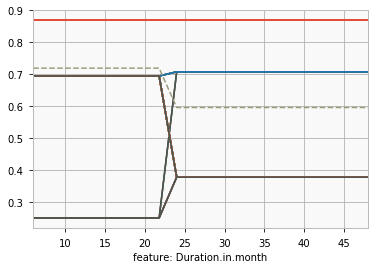

In [44]:
ax = ice_.plot(legend=False)
ice_.T.mean().plot(ax=ax, linestyle = '--')

In [40]:
ice_.T.mean()

feature: Duration.in.month
6.0     0.718787
10.0    0.718787
12.0    0.718787
18.0    0.718787
21.8    0.718787
24.0    0.595574
31.5    0.595574
36.0    0.595574
48.0    0.595574
dtype: float64